In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

2023-06-02 17:49:04.066534: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [130]:
vueltas = pd.read_csv("../dataset_todos_pilotos/final/laps_spain_final_v2.csv ")


In [131]:
vueltas

,LapTime,LapNumber,TyreLife,FreshTyre,TrackStatus,Stint,Piloto,makeStop,AirTemp,Rainfall,...,posicionActual,tiempoPilotoDelante,tiempoPilotoDetras,posicionSalida,anyo,nextPit,compound_HARD,compound_MEDIUM,compound_SOFT,compound_SUPERSOFT
0,132.826,3.0,4.0,0,4,1.0,hamilton,0,16.3,1,...,1.0,134.646,133.906,1.0,2018,25.0,0,0,1,0
1,128.778,4.0,5.0,0,4,1.0,hamilton,0,15.9,1,...,1.0,133.632,128.681,1.0,2018,25.0,0,0,1,0
2,130.044,5.0,6.0,0,4,1.0,hamilton,0,16.1,1,...,1.0,127.041,129.827,1.0,2018,25.0,0,0,1,0
3,133.088,6.0,7.0,0,4,1.0,hamilton,0,16.7,0,...,1.0,119.521,133.232,1.0,2018,25.0,0,0,1,0
4,82.099,7.0,8.0,0,1,1.0,hamilton,0,16.4,0,...,1.0,90.479,83.604,1.0,2018,25.0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5146,87.021,23.0,2.0,1,1,2.0,leclerc,0,37.1,0,...,1.0,90.757,88.555,1.0,2022,27.0,0,1,0,0
5147,87.196,24.0,3.0,1,1,2.0,leclerc,0,37.1,0,...,1.0,90.558,89.588,1.0,2022,27.0,0,1,0,0
5148,87.003,25.0,4.0,1,1,2.0,leclerc,0,37.0,0,...,1.0,92.489,88.079,1.0,2022,27.0,0,1,0,0
5149,87.279,26.0,5.0,1,1,2.0,leclerc,0,37.0,0,...,1.0,108.293,88.687,1.0,2022,27.0,0,1,0,0


In [132]:
list(vueltas.columns.values)

['LapTime',
 'LapNumber',
 'TyreLife',
 'FreshTyre',
 'TrackStatus',
 'Stint',
 'Piloto',
 'makeStop',
 'AirTemp',
 'Rainfall',
 'Humidity',
 'TrackTemp',
 'posicionActual',
 'tiempoPilotoDelante',
 'tiempoPilotoDetras',
 'posicionSalida',
 'anyo',
 'nextPit',
 'compound_HARD',
 'compound_MEDIUM',
 'compound_SOFT',
 'compound_SUPERSOFT']

In [133]:
columnas = ["Stint", "Piloto", 'anyo', 'makeStop']
vueltas = vueltas[columnas]

In [134]:

#vueltas = vueltas.drop(['Piloto'], axis = 1)

vueltas_train = vueltas[vueltas['anyo'].isin([2018, 2019, 2020])]
vueltas_validation = vueltas[vueltas['anyo'].isin([2021])]
vueltas_test = vueltas[vueltas['anyo'] == 2022]

#vueltas_test = vueltas_test[vueltas_test['Piloto'] == "alonso"]

vueltas_train = vueltas_train.drop(['anyo'], axis=1)
vueltas_validation = vueltas_validation.drop(['anyo'], axis=1)
vueltas_test = vueltas_test.drop(['anyo'], axis=1)
vueltas_train.drop(['Piloto'], axis = 1, inplace = True)
vueltas_test.drop(['Piloto'], axis = 1, inplace = True)
vueltas_validation.drop(['Piloto'], axis = 1, inplace = True)




vueltas_train = vueltas_train.astype(float)
vueltas_validation = vueltas_validation.astype(float)
vueltas_test = vueltas_test.astype(float)

In [135]:
sum(vueltas_test['Stint'] == 3.0)

350

In [136]:
sum(vueltas_test['makeStop'] ==1)

46

In [137]:
scaler = MinMaxScaler()
scaler.fit(vueltas_train)
vueltas_train_scaler = scaler.transform(vueltas_train)
vueltas_test_scaler = scaler.transform(vueltas_test)
vueltas_validation_scaler = scaler.transform(vueltas_validation)

In [138]:
pd.DataFrame(vueltas_train_scaler)

,0,1
0,0.000000,0.0
1,0.000000,0.0
2,0.000000,0.0
3,0.000000,0.0
4,0.000000,0.0
...,...,...
3038,0.333333,0.0
3039,0.333333,0.0
3040,0.333333,0.0
3041,0.333333,0.0


In [139]:
trainX = []
trainY = []
testX = []
testY = []
validationX = []
validationY = []
loopback = 8 # Esto es el numero de muestras que usara en el pasado 
future = 1 # Esto es el numero de hechos futuros que usará como salida a las 10 muestras del pasado

for i in range (loopback, len(vueltas_train_scaler) -future +1):
    trainX.append(vueltas_train_scaler[i-loopback:i, 0:vueltas_train.shape[1]])
    trainY.append(vueltas_train_scaler[i + future - 1:i + future, 0])
    
for i in range (loopback, len(vueltas_test_scaler) -future +1):
    if vueltas_test_scaler[i + future - 1:i + future,1]==1.0:
        testX.append(vueltas_test_scaler[i-loopback:i, 0:vueltas_test.shape[1]])
        testY.append(vueltas_test_scaler[i + future - 1:i + future,0])
        
    
for i in range (loopback, len(vueltas_validation_scaler) -future +1):
    validationX.append(vueltas_validation_scaler[i-loopback:i, 0:vueltas_validation.shape[1]])
    validationY.append(vueltas_validation_scaler[i + future - 1:i + future,0])

In [140]:
trainX, trainY, testX, testY, validationX, validationY = np.array(trainX), np.array(trainY), np.array(testX), np.array(testY), np.array(validationX), np.array(validationY)





In [141]:
testX = testX[:, :, :-1]
trainX = trainX[:, :, :-1]
validationX = validationX[:, :, :-1]

### Necesitamos quedarnos solo con aquellas ventanas de testX que unicamente tengan un cambio en la siguiente

In [88]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer="adam", loss= "mse") ##Cambiar esto para la siguiente reunion (positivo 1, negativo 0)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8, 256)            264192    
                                                                 
 dropout_2 (Dropout)         (None, 8, 256)            0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 461,441
Trainable params: 461,441
Non-trainable params: 0
_________________________________________________________________


Epoch 1/12
48/48 [==============================] - 4s 34ms/step - loss: 0.0354
Epoch 2/12
48/48 [==============================] - 2s 35ms/step - loss: 0.0172
Epoch 3/12
48/48 [==============================] - 2s 35ms/step - loss: 0.0157
Epoch 4/12
48/48 [==============================] - 2s 34ms/step - loss: 0.0141
Epoch 5/12
48/48 [==============================] - 2s 36ms/step - loss: 0.0128
Epoch 6/12
48/48 [==============================] - 2s 34ms/step - loss: 0.0113
Epoch 7/12
48/48 [==============================] - 2s 34ms/step - loss: 0.0113
Epoch 8/12
48/48 [==============================] - 2s 34ms/step - loss: 0.0107
Epoch 9/12
48/48 [==============================] - 2s 34ms/step - loss: 0.0103
Epoch 10/12
48/48 [==============================] - 2s 35ms/step - loss: 0.0103
Epoch 11/12
48/48 [==============================] - 2s 34ms/step - loss: 0.0104
Epoch 12/12
48/48 [==============================] - 2s 34ms/step - loss: 0.0098


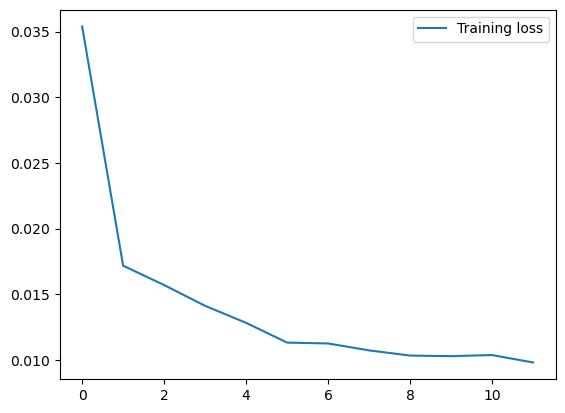

In [89]:
history = model.fit(trainX, trainY, epochs=12, batch_size=64, validation_split=0.0, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.legend()

In [129]:
clases = np.unique(trainY[:,0]) #Cuidado de donde sacamos las clases, deberiamos sacarlas de train, 
#pero si en 2021 hubo una parada mas por lo que sea, falla lo de abajo, lo he hecho con validationY pero
# y si hace una menos en validation?
clases

#Por ejemplo en arabia saudi solo hubo 3 paradas, por lo cual es 0, 0,5 y 1. Si en validation hay 5,
#ya no coinciden, es decir, no las va a predecir, que es lo que hablamos la semana anterior


array([0.        , 0.33333333, 0.66666667, 1.        ])

In [91]:
f = lambda x: np.argwhere(x == clases)
f = np.vectorize(f)
y_real = f(validationY[:,0])

In [92]:
#AQUI ES CON LOS DATOS DE VALIDADACION
predictions = model.predict(validationX)

33/33 [==============================] - 0s 8ms/step


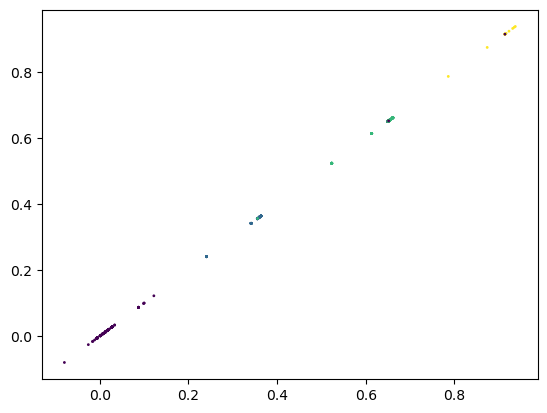

In [93]:
plt.scatter(predictions[:,0], predictions[:,0], s=1, c=y_real+1)

In [94]:
y_real_train = f(trainY[:,0])

In [95]:
predictions_test = model.predict(testX)

2/2 [==============================] - 0s 8ms/step


In [119]:
trainY

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.33333333],
       [0.33333333],
       [0.33333333]])

In [96]:
y_real_test =  f(testY[:,0])

In [109]:
predictions_test

array([[0.02671384],
       [0.35603473],
       [0.65174925],
       [0.02671384],
       [0.35603473],
       [0.65174925],
       [0.02671384],
       [0.35603473],
       [0.65174925],
       [0.35603473],
       [0.65174925],
       [0.02671384],
       [0.35603473],
       [0.02671384],
       [0.35603473],
       [0.65174925],
       [0.02671384],
       [0.35603473],
       [0.65174925],
       [0.02671384],
       [0.35603473],
       [0.65174925],
       [0.02671384],
       [0.35603473],
       [0.65174925],
       [0.02671384],
       [0.35603473],
       [0.02671384],
       [0.35603473],
       [0.65174925],
       [0.02671384],
       [0.35603473],
       [0.65174925],
       [0.02671384],
       [0.35603473],
       [0.02671384],
       [0.35603473],
       [0.65174925],
       [0.02671384],
       [0.35603473],
       [0.65174925],
       [0.17730522],
       [0.02671384],
       [0.35603473],
       [0.02671384],
       [0.02671384]], dtype=float32)

In [108]:
testY

array([[0.        ],
       [0.33333333],
       [0.66666667],
       [0.        ],
       [0.33333333],
       [0.66666667],
       [0.        ],
       [0.33333333],
       [0.66666667],
       [0.33333333],
       [0.66666667],
       [0.        ],
       [0.33333333],
       [0.        ],
       [0.33333333],
       [0.66666667],
       [0.        ],
       [0.33333333],
       [0.66666667],
       [0.        ],
       [0.33333333],
       [0.66666667],
       [0.        ],
       [0.33333333],
       [0.66666667],
       [0.        ],
       [0.33333333],
       [0.        ],
       [0.33333333],
       [0.66666667],
       [0.        ],
       [0.33333333],
       [0.66666667],
       [0.        ],
       [0.33333333],
       [0.        ],
       [0.33333333],
       [0.66666667],
       [0.        ],
       [0.33333333],
       [0.66666667],
       [0.33333333],
       [0.        ],
       [0.33333333],
       [0.        ],
       [0.        ]])

In [97]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(predictions, y_real, test_size=0.3, stratify=y_real)

In [98]:
from sklearn.linear_model import LogisticRegression
rl = LogisticRegression(random_state=0, penalty=None).fit(predictions, y_real) # Esto es de validacion

In [99]:
pred_test_2 = rl.predict(predictions_test)

In [100]:
cm = confusion_matrix(y_real_test, pred_test_2)
metricas = classification_report(y_real_test, pred_test_2)

In [101]:
print(cm)
print(metricas)

[[17  0  0]
 [ 1 16  0]
 [ 0  0 12]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.94      0.97        17
           2       1.00      1.00      1.00        12

    accuracy                           0.98        46
   macro avg       0.98      0.98      0.98        46
weighted avg       0.98      0.98      0.98        46



In [75]:
nombre_archivo = "ejecuciones/ejecuciones_val_2021/saudi_arabia.txt"

# Abrir el archivo en modo de escritura
with open(nombre_archivo, "w") as archivo:
    print("Matriz de confusión:", file=archivo)
    print(clases, file=archivo)
    print(cm, file=archivo)
    print("Métricas:", file=archivo)
    print(metricas, file=archivo)

In [103]:
trainX

array([[[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.        ],
        [0.        ],
        [0.        ]],

       ...,

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.33333333],
        [0.33333333],
        [0.33333333]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.33333333],
        [0.33333333],
        [0.33333333]],

       [[0.        ],
        [0.        ],
        [0.        ],
        ...,
        [0.33333333],
        [0.33333333],
        [0.33333333]]])